# Imports

In [2]:
import importlib
import functions as f  # Our defined functions
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
from tqdm.notebook import tqdm
import os
import math
import time

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

importlib.reload(f)

GRatio = (1 + 5 ** .5) / 2

WIDTH = .5
DASH = (10, 10)


# Solving models

In [4]:
importlib.reload(f)


t_final = {
    'SIRS_vars': 150,
    'SIRS_deaths': 120,
    'SIR_test3': 150,
    'SIS_deaths_2': 150,
    'SIS': 100,
    'SIR_betajump20': 125,
    'SIR': 125,
    'SIR2': 125,
    'SIR3': 200,
    'SIR_vars': 200
}


for modelName in ['SIR_vars']:

    model = f.loadModel(modelName, printText=False)
    solution, t_span = f.solve(model, (0, t_final[modelName]), 100)

    fig = plt.figure()
    f.plotCurves(t_span,
                 np.transpose(solution),
                  toPlot=list(range(solution.shape[1])),
                 labels=f.getCompartments(model),
                 title=modelName,
                 scales=['linear', 'linear'])

    plt.plot(t_span, f.infCurve(model, solution, t_span),
             label='Incident', c='#8E4585')

    plt.ylim(bottom=.1)
    plt.legend(loc='best')
    plt.axhline(y=1, linestyle='--', color='grey',
                linewidth=WIDTH, dashes=DASH)
    plt.yscale('log')

    f.mod(model, printText=False)

    model, modelMod, _, r0 = f.computeR0(
        modelName, (0, 300), printInit=False, printWarnings=False,
        scaledInfs=False, printText=False)

    print(r0)

    plt.show()


# $\mathcal{R}_t$ curves

In [59]:
parameters = {
    'SIR_deaths': {
        't_span_rt': (0, 80),
        'R0': 4,
        'legendLoc': 'center left'
    },
    'SIR_vars': {
        't_span_rt': (40, 90),
        'R0': 10,
        'legendLoc': 'center left'
    },
    'SIR_test2': {
        't_span_rt': (0, 175),
        'R0': 4,
        'legendLoc': 'center left'
    },
    'SIRS_vacc_morts': {
        't_span_rt': (0, 200),
        'R0': 32 / 15,
        'legendLoc': 'center left'
    },
    'SI': {
        't_span_rt': (0, 60),
        'R0': 0,
        'legendLoc': 'best'
    },
    'SIR': {
        't_span_rt': (0, 60),
        'R0': 4,
        'legendLoc': 'upper right'
    },
    'SIR copy': {
        't_span_rt': (0, 50),
        'R0': 2,
        'legendLoc': 'upper right'
    },
    'SIR2': {
        't_span_rt': (0, 50),
        'R0': 4,
        'legendLoc': 'center left'
    },
    'SIR_betajump20': {
        't_span_rt': (0, 60),
        'R0': 3,
        'legendLoc': 'upper right'
    },
    'SIR_gammajump20': {
        't_span_rt': (0, 60),
        'R0': 3,
        'legendLoc': 'upper right'
    },
    'SIR3': {
        't_span_rt': (0, 200),
        'R0': 3,
        'legendLoc': 'center left'
    }
}

  0%|          | 0/51 [00:00<?, ?it/s]

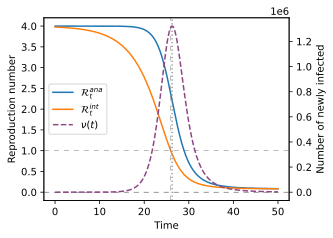

  0%|          | 0/201 [00:00<?, ?it/s]

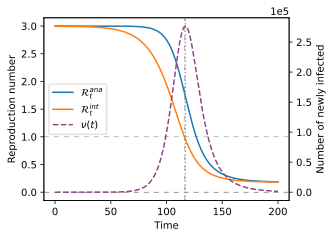

In [65]:
importlib.reload(f)

for name in ['SIR2', 'SIR3']:
    rtCurves = \
        f.compare(name, **parameters[name], sub_rt=1,
                  plotANA=True,
                  plotInfected=True,
                  title='',
                  useLog=False,
                  printText=False,
                  forceColors=False)
    plt.show()


  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

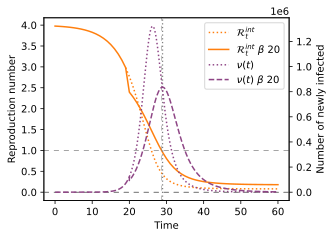

  0%|          | 0/61 [00:00<?, ?it/s]

  0%|          | 0/61 [00:00<?, ?it/s]

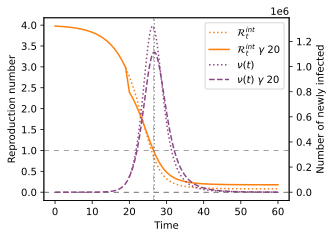

In [67]:
importlib.reload(f)

fig, ax1 = plt.subplots(figsize=(4*1.1, 3*1.1))
ax2 = ax1.twinx()

rtCurves = \
    f.compare('SIR', **parameters['SIR'], sub_rt=1,
              plotANA=False, plotANA_v2=False,
              susceptibles=[0],
              plotBound=False,
              plotInfected=True,
              title='',
              useLog=False,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              plotStyle=':',
              forceColors=True,
              drawVertical=False,
              saveGraph=False,
              plotFrom=20)
rtCurves = \
    f.compare('SIR_betajump20', **parameters['SIR_betajump20'], sub_rt=1,
              plotANA=False, plotANA_v2=False,
              susceptibles=[0],
              plotBound=False,
              plotInfected=True,
              title='',
              useLog=False,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              forceColors=True,
              saveGraph=True,
              graphName='betaJump',
              printR0=False,
              addToLegends=' $\\beta$ 20')
plt.show()

importlib.reload(f)

fig, ax1 = plt.subplots(figsize=(4*1.1, 3*1.1))
ax2 = ax1.twinx()

rtCurves = \
    f.compare('SIR', **parameters['SIR'], sub_rt=1,
              plotANA=False, plotANA_v2=False,
              susceptibles=[0],
              plotBound=False,
              plotInfected=True,
              title='',
              useLog=False,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              plotStyle=':',
              forceColors=True,
              drawVertical=False,
              saveGraph=False,
              plotFrom=20)
rtCurves = \
    f.compare('SIR_gammajump20', **parameters['SIR_gammajump20'], sub_rt=1,
              plotANA=False, plotANA_v2=False,
              susceptibles=[0],
              plotBound=False,
              plotInfected=True,
              title='',
              useLog=False,
              printText=False,
              whereToPlot=(fig, ax1, ax2),
              forceColors=True,
              saveGraph=True,
              graphName='gammaJump',
              printR0=False,
              addToLegends=' $\\gamma$ 20')
plt.show()


In [76]:
importlib.reload(f)

for name in  \
    ['SIS_deaths', 'SIS_vacc',
     'SIRS_deaths', 'SIS_deaths_2',
     'SIR_vars', 'SIR_test2',
     'SIR_deaths', 'SIR_test', 'SIR',
     'SIR_test3', 'SIRS_vars', 'SIRS_vacc_morts']:

    measures = {
        'layerDistance': 1,
        'nodeDistance': 2,
        'varDistance': .25,
        'nullDistance': .8,
        'baseAngle': 10,
        'contactPositions': ("2/5", "3/5"),
        'scale': .6
    }

    # f.printModel(f.loadModel(name, True, False))

    f.createLaTeX(f.loadModel(name, True, False), **measures)

    f.createLaTeX(f.mod(f.loadModel(name, True, False),
                        overWrite=True), **measures)


Tikz created for SIS_deaths
Tikz created for SIS_deaths_mod
Tikz created for SIS_vacc
Tikz created for SIS_vacc_mod
Tikz created for SIRS_deaths
Tikz created for SIRS_deaths_mod
Tikz created for SIS_deaths_2
Tikz created for SIS_deaths_2_mod
Tikz created for SIR_vars
Tikz created for SIR_vars_mod
Tikz created for SIR_test2
Tikz created for SIR_test2_mod
Tikz created for SIR_deaths
Tikz created for SIR_deaths_mod
Tikz created for SIR_test
Tikz created for SIR_test_mod
Tikz created for SIR
Tikz created for SIR_mod
Tikz created for SIR_test3
Tikz created for SIR_test3_mod
Tikz created for SIRS_vars
Tikz created for SIRS_vars_mod
Tikz created for SIRS_vacc_morts
Tikz created for SIRS_vacc_morts_mod
